<a href="https://colab.research.google.com/github/arthurvaz05/Python.Script/blob/master/forecast2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalação bibliotecas

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.9 MB/s eta 0:00:00


In [ ]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


# Bibliotecas

In [ ]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

In [ ]:
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "seaborn"
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [ ]:
# Configuration warnings
# ==============================================================================
import warnings

# Metadados

Os dados deste documento representam o uso horário do sistema de bicicletas compartilhadas na cidade de Washington, D.C. durante os anos de 2011 e 2012. Além do número de usuários por hora, estão disponíveis informações sobre condições climáticas e feriados. Os dados originais foram obtidos do [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) e foram previamente limpos (código) aplicando as seguintes modificações:

Colunas renomeadas com nomes mais descritivos.

Categorias renomeadas das variáveis meteorológicas. A categoria de heavy_rain foi combinada com a de chuva.

Variáveis desnormalizadas de temperatura, umidade e vento.

Variável date_time criada e definida como index.

Valores ausentes imputados por preenchimento direto.

O conjunto de dados resultante contém as colunas:

- date_time: data e hora.

- mês: mês (1 a 12).

- hora: hora (0 a 23).

- feriado: se o dia é feriado ou não (retirado de http://dchr.dc.gov/page/holiday-schedule).

- weekday: dia da semana (Segunda = 0, Domingo = 6).

- workingday: se for um dia útil.

- tempo: o clima do dia (claro, neblina, chuva).

- temp: temperatura registrada.

- atemp: sensação térmica.

- hum: umidade registrada.

- velocidade do vento: velocidade do vento registrada.

- users: número total de usuários do serviço de aluguel de bicicletas.

In [ ]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()
data = data.drop(columns=['workingday'])
data.head()

,holiday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,
2011-01-01 00:00:00,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,clear,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,clear,9.02,13.635,80.0,0.0,32.0,1,2,5
2011-01-01 03:00:00,0.0,clear,9.84,14.395,75.0,0.0,13.0,1,3,5
2011-01-01 04:00:00,0.0,clear,9.84,14.395,75.0,0.0,1.0,1,4,5


Para facilitar o treinamento dos modelos, a busca por hiperparâmetros ótimos e a avaliação de sua precisão preditiva, os dados são divididos em três conjuntos separados: treinamento, validação e teste.

In [ ]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


# Exploração dos dados

A exploração gráfica de séries temporais pode ser uma forma eficaz de identificar tendências, padrões e variações sazonais. Isso, por sua vez, ajuda a orientar a seleção de possíveis defasagens que podem servir como fortes preditores no modelo.

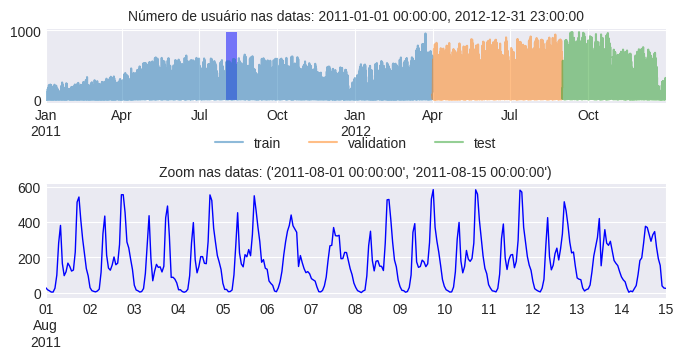

In [ ]:
# Plot time series with zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')

fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data_train['users'].plot(ax=main_ax, label='train', alpha=0.5)
data_val['users'].plot(ax=main_ax, label='validation', alpha=0.5)
data_test['users'].plot(ax=main_ax, label='test', alpha=0.5)

#O máximo e o mínimo servem para delimitar todo o retangulo da área selecionada pelo zoom
min_y = min(data['users'])
max_y = max(data['users'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)

main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
data.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Número de usuário nas datas: {data.index.min()}, {data.index.max()}', fontsize=10)
zoom_ax.set_title(f'Zoom nas datas: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

# Sazonalidade

In [ ]:
# Daily seasonality
# ==============================================================================
mean_day_hour = data.groupby(["weekday", "hour"])["users"].mean()
mean_day_hour

weekday  hour
0        0        34.009524
         1        17.352381
         2        10.180952
         3         5.266667
         4         5.780952
                    ...    
6        19      225.476190
         20      168.028571
         21      127.647619
         22       94.123810
         23       61.895238
Name: users, Length: 168, dtype: float64

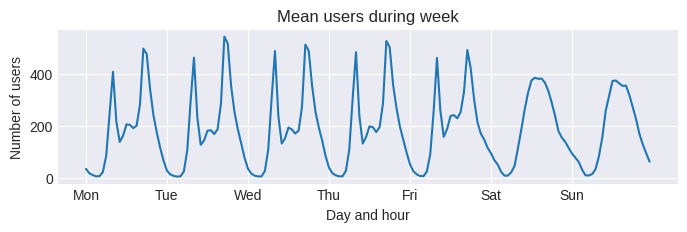

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2))
mean_day_hour.plot(ax=ax)
ax.set(
    title="Mean users during week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Day and hour",
    ylabel="Number of users"
);

Há uma clara diferença entre dias de semana e fins de semana. Há também um claro padrão intradiário, com diferentes fluxos de usuários dependendo da hora do dia.

# Autocorrelação

Os gráficos de autocorrelação podem ajudar a identificar padrões em seus dados de série temporal. Se o gráfico de autocorrelação mostrar uma alta autocorrelação em um atraso específico, isso indica que há uma forte relação entre as observações nesse atraso e, portanto, esse atraso pode ser um preditor útil.

Vamos aprofundar um pouco mais sobre o tema de ACF, PACF e White noise (ruído branco).

Basicamente ACF é para identificar correlação na série temporal, assim identificar sazonalidade e tendências. Já a PACF, ela consegue nos dizer se a série existe alguma correlação pura, excluindo efeitos indiretos (considera a aplicação de uma regressão no tempo t, t-1...t-n afim de considerar apenas os coeficientes de cada Lag da variável gerado) e por fim, para casos que não há nenhum tipo de autocorrelação, nos dizemos que a série é um White noise.

---



---



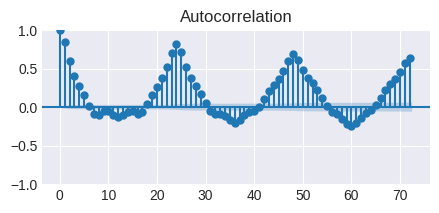

In [ ]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data['users'], ax=ax, lags=72)
plt.show()

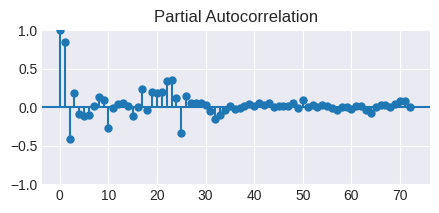

In [ ]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data['users'], ax=ax, lags=72, method='ywm')
plt.show()

Os resultados do estudo de autocorrelação mostram que existe uma correlação significativa entre o número de usuários nas horas anteriores, bem como nos dias anteriores, e o número de usuários no futuro. Isso significa que saber o número de usuários durante determinados períodos no passado pode ser valioso para prever o número de usuários no futuro.

# XGBoost

O XGBoost é uma implementação altamente eficiente do algoritmo de aumento de gradiente estocástico, que se tornou uma referência no campo do aprendizado de máquina. A biblioteca XGBoost inclui sua própria API, bem como a classe XGBRegressor, que segue a API scikit-learn, tornando-a compatível com skforecast.

Primeiro, um modelo autorregressivo é treinado usando valores passados (lags) da variável de resposta como preditores. Posteriormente, variáveis exógenas são adicionadas ao modelo e é avaliada a melhora em seu desempenho.

Os modelos Gradient Boosting têm um grande número de hiperparâmetros, portanto, uma combinação da estratégia grid_search e backtesting é usada para identificar a melhor configuração que fornece as previsões mais precisas.

Não é comum a utilização, mas você pode usar o XGBoost para previsão de séries temporais. No entanto, primeiro você precisa dividir seus dados de série temporal em pares (recursos, destino).
Defina o comprimento da janela (também conhecido como tamanho do vetor de recursos) e o tamanho da etapa (para controlar a granularidade) e iteração.

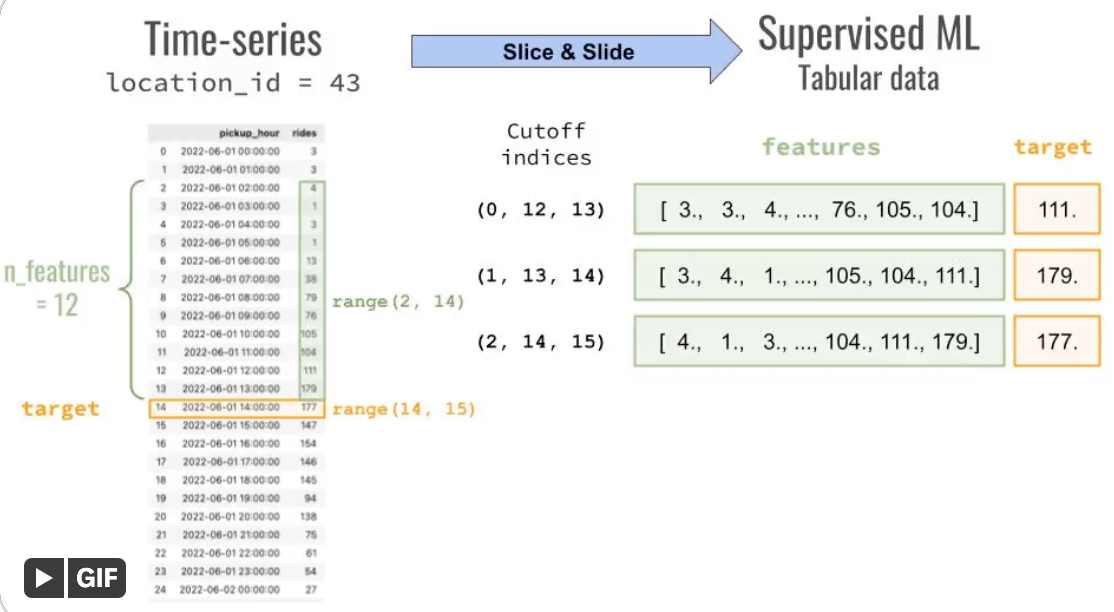

Fonte: https://twitter.com/paulabartabajo_/status/1663047089016668164

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags = 24
             )

# Ajustandos os hiperparâmetros

O ajuste de hiperparâmetros é uma etapa crítica no desenvolvimento de modelos eficazes de aprendizado de máquina. É importante observar que, ao pesquisar hiperparâmetros, os dados de teste não devem ser incluídos no processo. Isso ocorre porque a inclusão de dados de teste pode levar ao sobreajuste do modelo.

Para evitar overfitting, é realizada uma busca onde cada combinação de hiperparâmetros e lags é testada da seguinte forma:

Treine o modelo usando apenas o conjunto de treinamento.

O modelo é avaliado usando o conjunto de validação via backtesting.

A combinação de hiperparâmetros e defasagens que fornece o menor erro é selecionada.

Treine o modelo novamente usando a melhor combinação encontrada, desta vez usando os dados de treinamento e validação.

Seguindo essas etapas, pode-se obter um modelo com hiperparâmetros otimizados e evitar o overfitting.

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'], # Train and validation data
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 13132.573900322006



In [ ]:
# Results of grid search
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",13132.573900,0.1,5.0,500.0
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",14407.853484,0.1,5.0,100.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",14677.093172,0.1,5.0,500.0
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",14959.220470,0.1,10.0,100.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",15135.992088,0.1,3.0,500.0


Como **return_best = True**, o objeto de previsão será atualizado com a melhor configuração encontrada e treinada em todo o conjunto de dados. Isso significa que o modelo final obtido da busca em grid terá a melhor combinação de lags e hiperparâmetros que resultaram na métrica de maior desempenho. Esse modelo final pode então ser usado para previsões futuras sobre novos dados.

# Período de teste de backtesting

Uma vez identificada a melhor combinação de hiperparâmetros a partir dos dados de validação, avalia-se a capacidade preditiva do modelo quando aplicado ao conjunto de teste. A função backtesting_forecaster é usada para simular o processo de previsão a cada 36 horas em nosso exemplo.

Recomenda-se revisar a documentação da função backtesting_forecaster para entender melhor seus recursos. Isso ajudará a utilizar todo o seu potencial para analisar a capacidade preditiva do modelo.

In [ ]:
# Backtesting on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['users'],
                            initial_train_size = len(data.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps              = 36,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False # Change to True to see detailed information
                      )        

print(f"Backtest error: {metric:.2f}")
predictions.head()

  0%|          | 0/82 [00:00<?, ?it/s]

Backtest error: 11600.73


,pred
2012-09-01 00:00:00,127.918144
2012-09-01 01:00:00,73.119354
2012-09-01 02:00:00,44.164623
2012-09-01 03:00:00,22.474485
2012-09-01 04:00:00,8.992602


In [ ]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Users",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

# Características exógenas

Além de usar preditores autorregressivos obtidos do passado da própria variável resposta, é possível adicionar outras variáveis exógenas. Neste caso, estão disponíveis informações de calendário (mês, dia da semana, hora, feriados, ...) e variáveis meteorológicas (vento, temperatura, humidade, ...).

**Cuidado que precisamos ter!**

*O uso de variáveis meteorológicas deve ser feito com cautela. Quando o modelo é implantado em produção, as condições meteorológicas futuras não são conhecidas, mas são previsões feitas pelos serviços meteorológicos. Como são previsões, elas introduzem erros no modelo de previsão. Como consequência, as previsões do modelo tendem a piorar. Uma forma de antecipar esse problema e saber (não evitar) o desempenho esperado do modelo é usar as previsões meteorológicas disponíveis no momento do treinamento do modelo, em vez das condições registradas.*

# Recursos contínuos com um padrão cíclico

Variáveis contínuas que possuem um padrão cíclico, como horas, podem ser tratadas de várias maneiras, cada uma com suas vantagens e desvantagens.

Uma abordagem é usar os recursos diretamente como valores numéricos sem qualquer transformação. Este método evita a geração de inúmeras novas características, mas pode impor uma ordem linear incorreta nos valores. Por exemplo, a hora 23 de um dia e a hora 00 do outro estão muito distantes quando na verdade há apenas uma hora de diferença entre elas.

Outra possibilidade é tratar características cíclicas como variáveis categóricas para evitar a imposição de uma ordem linear. No entanto, esta abordagem pode resultar na perda da informação cíclica inerente à variável.

Existe uma terceira maneira de lidar com características cíclicas que geralmente é preferida aos outros dois métodos. Isso envolve transformar os recursos usando o seno e o cosseno de seu período. Essa abordagem gera apenas dois novos recursos que capturam a ciclicidade dos dados de forma mais precisa do que os dois métodos anteriores porque preserva a ordem natural do recurso e evita impor uma ordem linear.

In [ ]:
# Transformation sine-cosine of variable hour
# ==============================================================================
data['hour_sin'] = np.sin(data['hour'] / 23 * 2 * np.pi)
data['hour_cos'] = np.cos(data['hour'] / 23 * 2 * np.pi)

# Variável categórica

Embora as variáveis 'mês', 'dia da semana', 'clima' e 'feriado' sejam armazenadas como valores numéricos, na verdade são variáveis categóricas. Portanto, é importante converter seu tipo de dados para categórico para evitar que o modelo os interprete como recursos numéricos. Isso ajudará a garantir que o modelo seja capaz de capturar com precisão as características e padrões exclusivos dessas variáveis.

In [ ]:
# Store categorical variables as category type
# ==============================================================================
data["holiday"] = data["holiday"].astype("category")
data["weather"] = data["weather"].astype("category")
data["month"]   = data["month"].astype("category")
data["weekday"] = data["weekday"].astype("category")

Existem várias abordagens para incorporar variáveis categóricas no XGBoost (e outras estruturas de aumento de gradiente):

Uma opção é transformar os dados convertendo valores categóricos em valores numéricos usando métodos como codificação one-hot ou codificação ordinal. Essa abordagem é aplicável a todos os modelos de aprendizado de máquina.

Como alternativa, o XGBoost pode manipular variáveis categóricas internamente sem a necessidade de pré-processamento. Isso pode ser feito automaticamente definindo o parâmetro enable_categorical='auto' e codificando as variáveis como o tipo de dados da categoria dentro de um Pandas DataFrame. Como alternativa, os usuários podem especificar o tipo de categoria de cada recurso usando o parâmetro feature_dtype.

**Importante!**

*Não existe um método que sempre supere os outros. As regras gerais são:
Quando a cardinalidade das variáveis categóricas é alta (muitos valores diferentes), é melhor usar o suporte nativo para variáveis categóricas do que usar a codificação one-hot.*

*Com dados codificados em um ponto, são necessários mais pontos de divisão (ou seja, mais profundidade) para recuperar uma divisão equivalente que pode ser obtida com um único ponto de divisão usando manipulação nativa.*

*Quando uma variável categórica é convertida em múltiplas variáveis dummy usando one-hot, sua importância é diluída, tornando a análise da importância dos atributos mais complexa de interpretar.*

# One hot encoding

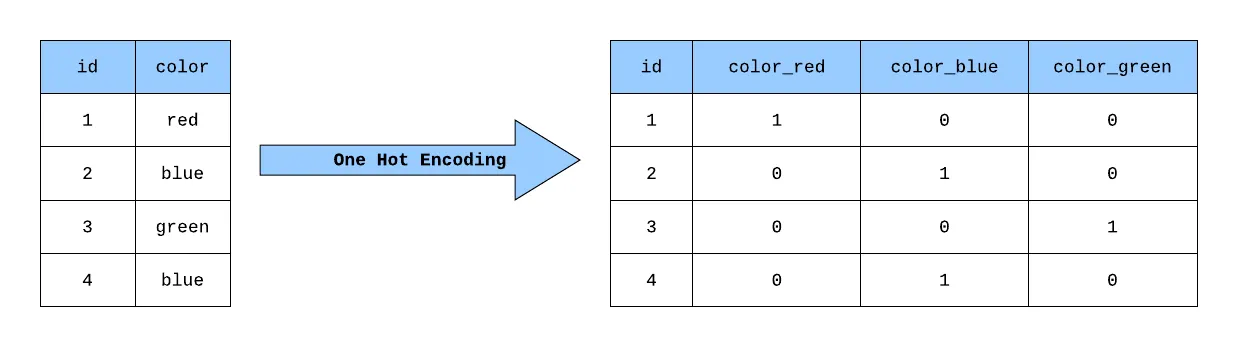

Fontes: https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39

ColumnTransformers no scikit-learn fornecem uma maneira poderosa de definir transformações e aplicá-las a recursos específicos. Ao encapsular as transformações em um objeto ColumnTransformer, ele pode ser passado para um previsor usando o argumento Transformer_exog.

**Observação**

*A aplicação de uma transformação a todo o conjunto de dados independente do previsor é viável. No entanto, é crucial garantir que as transformações sejam aprendidas apenas com os dados de treinamento para evitar vazamento de informações. Além disso, a mesma transformação deve ser aplicada aos dados de entrada durante a previsão. Portanto, é aconselhável incluir a transformação no previsor, para que seja tratada internamente. Essa abordagem garante consistência na aplicação de transformações e reduz a probabilidade de erros.*

In [ ]:
# One hot encoding transformer
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          make_column_selector(dtype_exclude=np.number),
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [ ]:
# Create forecaster with a transformer for exogenous features
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = XGBRegressor(random_state=123),
                 lags             = 24,
                 transformer_exog = one_hot_encoder
             )

Para examinar como os dados são transformados, é possível usar o método create_train_X_y para gerar as matrizes que o previsor usa para treinar o modelo. Essa abordagem fornece informações sobre as manipulações de dados específicas que ocorrem durante o processo de treinamento.

In [ ]:
# View Training Matrix
# ==============================================================================
exog_features = ['weather', 'month', 'weekday', 'hour_sin', 'hour_cos', 'holiday',
                 'temp', 'atemp', 'hum', 'windspeed']
                 
X_train, y_train = forecaster.create_train_X_y(
                        y = data.loc[:end_validation, 'users'],
                        exog = data.loc[:end_validation, exog_features]
                   )
X_train.head(3)

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

# Implementação nativa para recursos categóricos

As bibliotecas Gradient Boosting (XGBoost, LightGBM, CatBoost e HistGradientBoostingRegressor) assumem que as categorias de entrada são inteiros começando de 0 até o número de categorias [0, 1, ..., n_categories-1]. Na maioria dos casos reais, as variáveis categóricas não são codificadas com números, mas com strings, portanto, uma etapa intermediária de transformação é necessária. Duas opções são:

Defina colunas com variáveis categóricas para a categoria de tipo. Internamente, essa estrutura de dados consiste em uma matriz de categorias e uma matriz de valores inteiros (códigos) que apontam para o valor real da matriz de categorias. Ou seja, internamente é um array numérico com um mapeamento que relaciona cada valor a uma categoria. Os modelos são capazes de identificar automaticamente as colunas da categoria de tipo e acessar seus códigos internos. Essa abordagem é aplicável a XGBoost, LightGBM e CatBoost.

Pré-processe as colunas categóricas com um OrdinalEncoder para transformar seus valores em números inteiros e, em seguida, indique explicitamente quais recursos devem ser tratados como categóricos.

Para usar a detecção automática no skforecast, as variáveis categóricas devem primeiro ser codificadas como números inteiros e, em seguida, armazenadas como categoria de tipo novamente. Isso ocorre porque o skforecast usa internamente uma matriz numpy numérica para acelerar o cálculo.

**⚠ Aviso**

*Ao implantar modelos em produção, é altamente recomendável evitar o uso de detecção automática com base em colunas do tipo `category` do pandas. Embora o pandas forneça uma codificação interna para essas colunas, ela não é consistente em diferentes conjuntos de dados e pode variar dependendo das categorias presentes em cada conjunto de dados. Portanto, é crucial estar ciente desse problema e tomar as medidas apropriadas para garantir consistência na codificação de recursos categóricos ao implantar modelos em produção. Mais detalhes sobre esse problema podem ser encontrados em Implementação nativa para recursos categóricos.*

In [ ]:
# Transformer: Ordinal encoding + cast to category type
# ==============================================================================
pipeline_categorical = make_pipeline(
                            OrdinalEncoder(
                                dtype=int,
                                handle_unknown="use_encoded_value",
                                unknown_value=-1,
                                encoded_missing_value=-1
                            ),
                            FunctionTransformer(
                                func=lambda x: x.astype('category'),
                                feature_names_out= 'one-to-one'
                            )
                       )

transformer_exog = make_column_transformer(
                        (
                            pipeline_categorical,
                            make_column_selector(dtype_exclude=np.number)
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

In [ ]:
# Create forecaster, Automatic categorical detection
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(
                                 tree_method = 'hist',
                                 enable_categorical = 'auto',
                                 random_state = 123
                             ),
                 lags = 24,
                 transformer_exog = transformer_exog
             )

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

A inclusão de variáveis exógenas como preditoras reduziu o erro de previsão em mais da metade. Os resultados obtidos usando a codificação one-hot (erro de backtest de 6330) são muito semelhantes aos obtidos usando a implementação nativa de XGBoost para variáveis categóricas (erro de backtest de 6317).

# Feature importances

Uma vantagem de evitar a codificação one-hot é que ela evita o aumento do número de features, o que facilita a interpretação. Isso pode levar a uma análise mais simples e a uma melhor compreensão dos dados, pois há menos variáveis a serem consideradas.

In [ ]:
# Extract feature importances
# ==============================================================================
importance = forecaster.get_feature_importances()
importance

# LightGBM, CatBoost and HistGradientBoostingRegressor

Desde o sucesso do XGBoost como algoritmo de aprendizado de máquina, foram desenvolvidas novas implementações que também alcançam excelentes resultados, três delas são:

LightGBM: desenvolvido pela Microsoft.

HistGradientBoostingRegressor: desenvolvido por scikit-learn.

CatBoost: desenvolvido por Yandex.

Aqui está como usá-los no skforecast.

# LightGBM

O Light GBM cresce a árvore verticalmente, enquanto outro algoritmo cresce as árvores horizontalmente, o que significa que o Light GBM cresce a árvore em forma de folha (leaf-wise), enquanto outro algoritmo cresce em nível (level-wise). Ele escolherá a folha com perda delta máxima para crescer. Ao cultivar a mesma folha, o algoritmo Leaf-wise pode reduzir mais perdas do que um algoritmo level-wise.

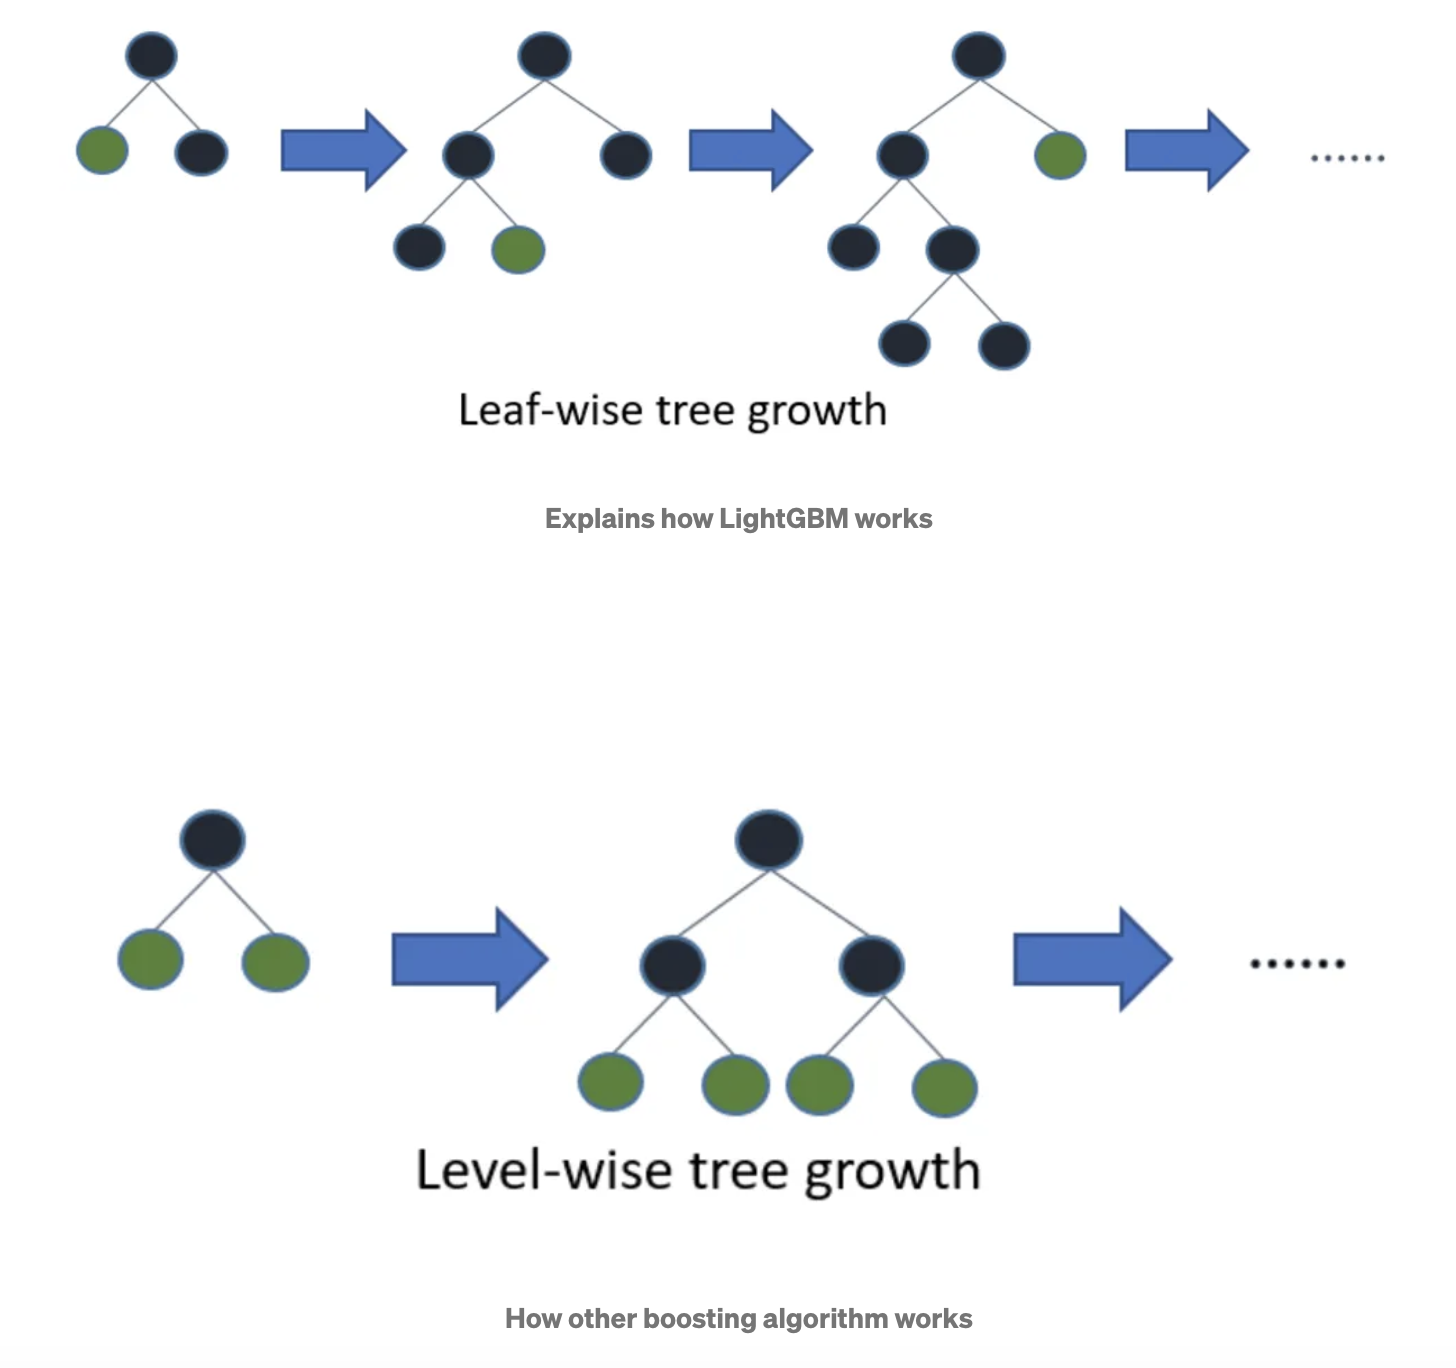

Fontes: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

Por que o Light GBM está ganhando popularidade?

O tamanho dos dados está aumentando dia a dia e está se tornando difícil para os algoritmos tradicionais de ciência de dados fornecer resultados mais rápidos. Light GBM é prefixado como 'Light' por causa de sua alta velocidade. O GBM leve pode lidar com o grande tamanho de dados e requer menos memória para ser executado. Outra razão pela qual o Light GBM é popular é porque ele se concentra na precisão dos resultados. O LGBM também oferece suporte ao aprendizado de GPU e, portanto, os cientistas de dados estão usando amplamente o LGBM para o desenvolvimento de aplicativos de ciência de dados.

Podemos usar o Light GBM em qualquer conjunto de dados?

Não, não é aconselhável usar LGBM em pequenos conjuntos de dados. O GBM leve é sensível ao superajuste e pode facilmente sobreajustar dados pequenos. Não há limite para o número de linhas, mas minha experiência sugere que eu o use apenas para dados com mais de 10.000 observações.

In [ ]:
# Transformer: Ordinal encoding + cast to category type
# ==============================================================================
pipeline_categorical = make_pipeline(
                           OrdinalEncoder(
                               dtype=int,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1,
                               encoded_missing_value=-1
                           ),
                           FunctionTransformer(
                               func=lambda x: x.astype('category'),
                               feature_names_out= 'one-to-one'
                           )
                       )

transformer_exog = make_column_transformer(
                       (
                           pipeline_categorical,
                           make_column_selector(dtype_exclude=np.number)
                       ),
                       remainder="passthrough",
                       verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(categorical_features='auto', random_state=123),
                lags = 24,
                transformer_exog = transformer_exog
             )

forecaster

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
warnings.filterwarnings('ignore')
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )
warnings.resetwarnings()

In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

# HistGradientBoostingRegressor

Esse algoritimo acaba sendo uma boa opção para quem busca performance, relativamente "novo" - foi desenvolvido em 1990, ele tem um jeito interessante em lidar com os dados. Basicamente, como o próprio nome já revela, ele agrupo como se fosse um histograma os dados e assim diminui seu tamanho consideravelmente.

Na sua documentação existe uma breve explicação bem intuitiva:

"*Esses estimadores rápidos primeiro agrupam as amostras de entrada X em compartimentos de valor inteiro (normalmente 256 compartimentos), o que reduz tremendamente o número de pontos de divisão a serem considerados e permite que o algoritmo alavanque estruturas de dados baseadas em números inteiros (histogramas) em vez de depender de contínuos classificados valores ao construir as árvores. A API desses estimadores é um pouco diferente e alguns dos recursos de GradientBoostingClassifier e GradientBoostingRegressor ainda não são suportados, por exemplo, algumas funções de perda.*"

Fontes: https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting

Encontrando uma outra explicação que ajuda no entendimento desse algoritmos:

"*A construção de árvores de decisão pode ser acelerada significativamente reduzindo o número de valores para recursos de entrada contínua. Isso pode ser obtido pela discretização ou categorização de valores em um número fixo de compartimentos. Isso pode reduzir o número de valores exclusivos para cada recurso de dezenas de milhares para algumas centenas.*

*Isso permite que a árvore de decisão opere no balde ordinal (um número inteiro) em vez de valores específicos no conjunto de dados de treinamento. Essa aproximação grosseira dos dados de entrada geralmente tem pouco impacto na habilidade do modelo, se não melhora a habilidade do modelo e acelera drasticamente a construção da árvore de decisão.*

*Além disso, estruturas de dados eficientes podem ser usadas para representar o agrupamento dos dados de entrada; por exemplo, histogramas podem ser usados e o algoritmo de construção de árvore pode ser ainda mais adaptado para o uso eficiente de histogramas na construção de cada árvore.*"

Fonte: https://machinelearningmastery.com/histogram-based-gradient-boosting-ensembles/

Ao criar um previsor usando HistogramGradientBoosting, os nomes das colunas categóricas devem ser especificados durante a instanciação do regressor, passando-os como uma lista para o argumento categorical_feature.

In [ ]:
# Transformer: ordinal encoding
# ==============================================================================
# A ColumnTransformer is used to transform categorical features (no numerical)
# using ordinal encoding. Numerical features are left untouched. Missing values
# are encoded as -1. If a new category is found in the test set, it is encoded
# as -1.
categorical_features = data.select_dtypes(exclude=[np.number]).columns.tolist()
transformer_exog = make_column_transformer(
                       (
                           OrdinalEncoder(
                               dtype=int,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1,
                               encoded_missing_value=-1
                           ),
                           categorical_features
                       ),
                       remainder="passthrough",
                       verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

In [ ]:
# Create forecaster
# ==============================================================================
categorical_features = data.select_dtypes(exclude=np.number).columns.to_list()

forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(
                                 categorical_features = categorical_features,
                                 random_state = 123
                             ),
                 lags = 24,
                 transformer_exog = transformer_exog
             )

forecaster

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

# CatBoost

CatBoost é um método de aprendizado de máquina supervisionado usado pela ferramenta Train Using AutoML e usa árvores de decisão para classificação e regressão. Como o próprio nome sugere, o CatBoost possui dois recursos principais: trabalha com dados categóricos (o Cat) e usa aumento de gradiente (o Boost). O aumento de gradiente é um processo no qual muitas árvores de decisão são construídas iterativamente. Cada árvore subseqüente melhora o resultado da árvore anterior, levando a melhores resultados. O CatBoost melhora o método de aumento de gradiente original para uma implementação mais rápida.

O CatBoost supera uma limitação de outros métodos baseados em árvore de decisão nos quais, normalmente, os dados devem ser pré-processados para converter variáveis categóricas de string em valores numéricos, codificações one-hot e assim por diante. Este método pode consumir diretamente uma combinação de variáveis explicativas categóricas e não categóricas sem pré-processamento. Ele pré-processa como parte do algoritmo. CatBoost usa um método chamado codificação ordenada para codificar recursos categóricos. A codificação ordenada considera as estatísticas de destino de todas as linhas antes de um ponto de dados para calcular um valor para substituir o recurso categórico.

Outra característica única do CatBoost é que ele usa árvores simétricas. Isso significa que em cada nível de profundidade, todos os nós de decisão usam a mesma condição de divisão.

Referência: https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/how-catboost-works.htm#:~:text=As%20its%20name%20suggests%2C%20CatBoost,tree%2C%20leading%20to%20better%20results.

Infelizmente, a versão atual do skforecast não é compatível com o tratamento integrado do CatBoost de recursos categóricos. O problema surge porque CatBoost aceita apenas recursos categóricos como números inteiros, enquanto skforecast converte dados de entrada em flutuantes para computação mais rápida usando matrizes numpy no processo de previsão interna. Para contornar essa limitação, é necessário aplicar a codificação one-hot ou a estratégia de codificação de rótulo aos recursos categóricos antes de usá-los com o CatBoost.

In [ ]:
# One hot encoding
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          make_column_selector(dtype_exclude=np.number),
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = CatBoostRegressor(
                                        random_state=123, 
                                        silent=True, 
                                        allow_writing_files=False
                                    ),
                 lags             = 24,
                 transformer_exog = one_hot_encoder
             )

forecaster

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

# Conclusão

Conforme mostrado neste documento, a inclusão de variáveis exógenas como preditores pode melhorar significativamente o desempenho da previsão.

O uso de modelos de aprendizado de máquina em problemas de previsão é muito fácil graças às funcionalidades oferecidas pelo skforecast.

Características categóricas podem ser incluídas como variáveis exógenas.

O modelo Gradient Boosting gerado pelo LightGBM tem um desempenho ligeiramente melhor do que as outras bibliotecas neste caso.

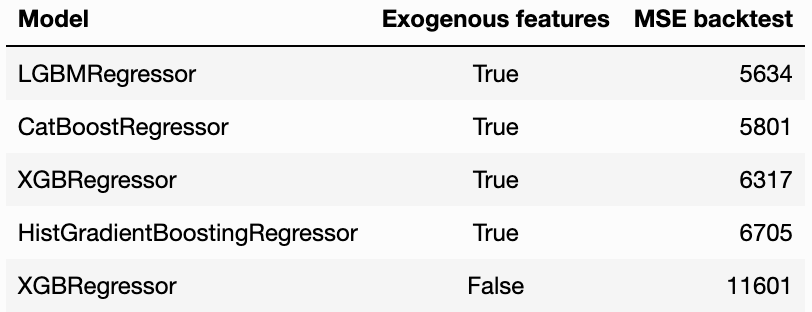

Observação

Para ilustrar o processo, a pesquisa de hiperparâmetros foi mantida pequena. No entanto, para obter resultados ótimos, pode ser necessário realizar uma pesquisa mais extensa para cada modelo.

In [ ]:
import session_info
session_info.show(html=False)

Referências:

Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html